In [284]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf 
from datetime import datetime, timedelta


In [285]:
stock = "HD"
data = yf.download(stock, interval="1d", period="max")
data.head()

C:\Windows\Temp\ipykernel_5780\2131587274.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, interval="1d", period="max")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,HD,HD,HD,HD,HD
Date,,,,,
1981-09-22,0.016743,0.016743,0.016743,0.016743,7449469
1981-09-23,0.016743,0.016743,0.016743,0.016743,7381125
1981-09-24,0.016743,0.016743,0.016743,0.016743,5091609
1981-09-25,0.016743,0.016743,0.016743,0.016743,7312781
1981-09-28,0.016743,0.016743,0.016743,0.016743,5809219


In [286]:
data["SMA_OPEN_50"] = data["Open"].rolling(window=50).mean()
data["SMA_OPEN_255"] = data["Open"].rolling(window=255).mean()
data = data.dropna()
data

Price,Close,High,Low,Open,Volume,SMA_OPEN_50,SMA_OPEN_255
Ticker,HD,HD,HD,HD,HD,,
Date,,,,,,,
1982-09-23,0.083845,0.083845,0.083845,0.083845,10479375,0.069335,0.042059
1982-09-24,0.083845,0.083845,0.083845,0.083845,2114100,0.069894,0.042322
1982-09-27,0.083845,0.083845,0.083845,0.083845,7053075,0.070453,0.042585
1982-09-28,0.089205,0.089205,0.089205,0.089205,6870825,0.071119,0.042869
1982-09-29,0.089205,0.089205,0.089205,0.089205,3553875,0.071785,0.043153
...,...,...,...,...,...,...,...
2025-12-15,356.989990,362.670013,355.619995,359.390015,4387400,366.699553,375.099146
2025-12-16,352.679993,358.739990,351.809998,356.899994,3497200,365.998256,374.844506


C:\Windows\Temp\ipykernel_5780\2122533195.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


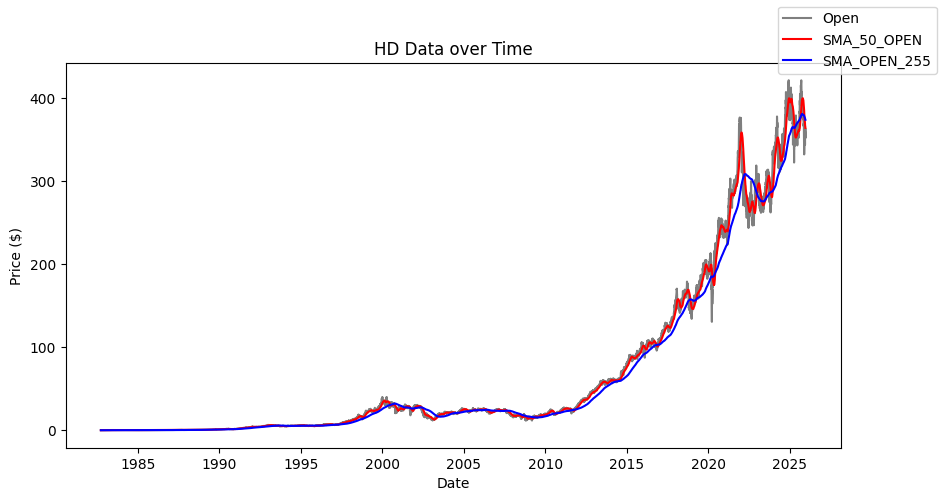

In [287]:
fig, ax = plt.subplots()

look_back = 0
ax.plot(data.index[look_back:], data["Open"][look_back:], label="Open", color="black", alpha=0.5)
ax.plot(data.index[look_back:], data["SMA_OPEN_50"][look_back:], label="SMA_50_OPEN", color="r")
ax.plot(data.index[look_back:], data["SMA_OPEN_255"][look_back:], label="SMA_OPEN_255", color="b")
ax.set_title(f"{stock} Data over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
fig.legend()
fig.set_size_inches([10,5])
fig.show()


In [288]:
def plot_buy_sell(ax, action, date):
    """ Action: Buy, Sell"""

    # Standardize action and date    
    action = action.lower()
    date = pd.to_datetime(date)

    # if date isnt in df get nearest date in future or raise index error
    if date not in data.index: 
        idx = data.index.get_indexer([date], method="backfill")[0]

        if idx == -1:
            raise IndexError(f"Date: {date} not in df can not find date") 

        date = data.index[idx]

    # Change "SMA_OPEN_50" to somthing else if you want to change where indicator is placed
    price = data.loc[date, "SMA_OPEN_50"]

    # If label is alread plotted no need to plot again 
    label = "Sell" if action == "sell" else "Buy"
    labels = ax.get_legend_handles_labels()[1]
    use_label = label if label not in labels else None

    # Plot 
    ax.scatter(
        date, price,
        color="red" if action == "sell" else "blue",
        marker="v" if action == "sell" else "^",
        s=100, alpha=1,
        label=use_label
    )

## Sanity Check that my plot function work for plotting sell / buy indicators

C:\Windows\Temp\ipykernel_5780\1590857280.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


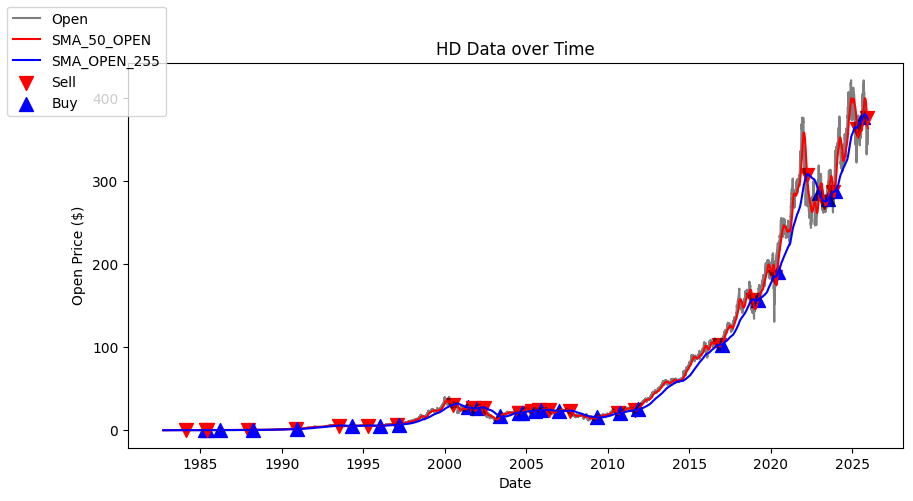

In [289]:
fig, ax = plt.subplots()

cooldown_days = 1
df = data.iloc[look_back:].copy()

ax.plot(df.index, df["Open"], label="Open", color="black", alpha=0.5)
ax.plot(df.index, df["SMA_OPEN_50"], label="SMA_50_OPEN", color="r")
ax.plot(df.index, df["SMA_OPEN_255"], label="SMA_OPEN_255", color="b")

# Spread and sign
spread = df["SMA_OPEN_50"] - df["SMA_OPEN_255"]
sign = np.sign(spread)

# Cross happens when sign changes (ignore zeros by forward filling)
# Thanks CHAT for this holy 
sign = sign.replace(0, np.nan).ffill()
cross = sign.ne(sign.shift(1))  # True on crossover dates
cross_dates = df.index[cross.fillna(False)]

last_plotted_date = None

for date in cross_dates:
    if last_plotted_date is None or (date - last_plotted_date).days >= cooldown_days:
        # Determine direction of cross:
        # if spread goes from negative -> positive => golden cross (buy)
        prev_spread = spread.loc[:date].iloc[-2] if spread.loc[:date].shape[0] >= 2 else np.nan
        curr_spread = spread.loc[date]

        if prev_spread < 0 and curr_spread > 0:
            #if buy_order_place(date, ammount):
                plot_buy_sell(ax, "buy", date)
                last_plotted_date = date

        elif prev_spread > 0 and curr_spread < 0:
            #if sell_order_place(date, ammount):
                plot_buy_sell(ax, "sell", date)
                last_plotted_date = date




ax.set_title(f"{stock} Data over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Open Price ($)")
fig.legend(loc="upper left")
fig.set_size_inches([10, 5])
fig.show()

## This works but I need to add order logic for selling and buying.
- I can not sell what I dont own
- I can only buy what I can afford to own
- I Need to keep track of trades (open and closed trades with date)
- I Need to track portfolio ammount over time

In [290]:
"""
trade = {
    "type": "buy",          # "buy" or "sell"
    "date": date,           # pd.Timestamp
    "price": price,         # execution price 
    "shares": shares,       # number of shares - not yet
    "notional": price * shares, - not yet
}

"""

class Investor:
    def __init__(self, strategy, cash=10_000):
        self.strategy = strategy
        self.cash = float(cash)
        self.shares = 0.0
        self.position_open = False
        self.trades = []


def buy(investor: Investor, date: str, price: float, shares: float):
    if investor.position_open:          # can't buy twice
        return 0
    if shares <= 0:
        return 0

    cost = shares * price
    if cost > investor.cash:            # can't buy what you can't afford
        return 0

    investor.cash -= cost
    investor.shares = shares            # single position => overwrite/own exactly this position size
    investor.position_open = True

    investor.trades.append({
        "type": "buy", 
        "date": date,
        "price": price,
        "shares": shares, 
        "notional": cost
    })
    return 1


def sell(investor: Investor, date: str, price: float):
    if not investor.position_open:      # can't sell twice in a row
        return 0
    if investor.shares <= 0:
        return 0

    proceeds = investor.shares * price
    investor.cash += proceeds

    investor.trades.append({
        "type": "sell", 
        "date": date, 
        "price": price,
        "shares": investor.shares, 
        "notional": proceeds
    })

    investor.shares = 0.0
    investor.position_open = False
    return 1


def place_order(investor: Investor, side: str, date: str, price: float, shares: float = 0.0):
    side = side.lower()
    if side == "buy":
        buy(investor, date, price, shares)
        return 1
    elif side == "sell":
        sell(investor, date, price)
        return 1
    else:
        return 0 


inv = Investor("foo", cash=10_000)

place_order(inv, "buy",  "2025-01-12", price=100, shares=50) 
place_order(inv, "buy",  "2025-01-13", price=101, shares=10) 
place_order(inv, "sell", "2025-01-14", price=110)             
place_order(inv, "sell", "2025-01-15", price=111)             

print(inv.cash, inv.shares, inv.position_open)
print(inv.trades)


10500.0 0.0 False
[{'type': 'buy', 'date': '2025-01-12', 'price': 100, 'shares': 50, 'notional': 5000}, {'type': 'sell', 'date': '2025-01-14', 'price': 110, 'shares': 50, 'notional': 5500}]


C:\Windows\Temp\ipykernel_5780\2323871286.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


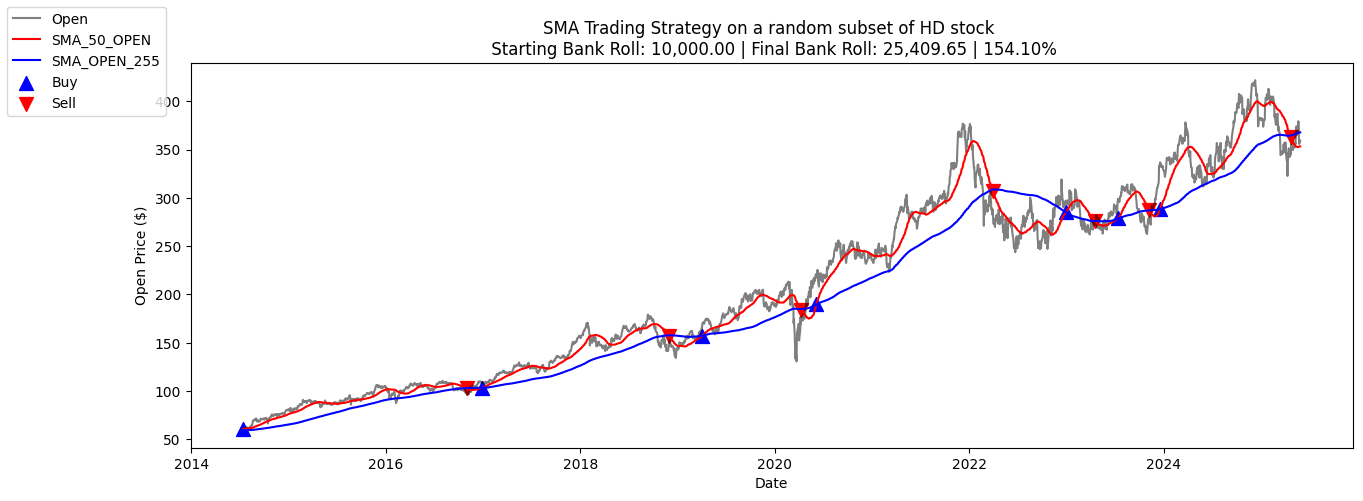

In [291]:
fig, ax = plt.subplots()

starting_ammunt = 10_000
inv = Investor("foo", cash=starting_ammunt)


cooldown_days = 1

rng = np.random.default_rng()
start = rng.integers(0, len(data.index))
end = rng.integers(start+1, len(data.index))

df = data.iloc[start:end].copy()

ax.plot(df.index, df["Open"], label="Open", color="black", alpha=0.5)
ax.plot(df.index, df["SMA_OPEN_50"], label="SMA_50_OPEN", color="r")
ax.plot(df.index, df["SMA_OPEN_255"], label="SMA_OPEN_255", color="b")

# Spread and sign
spread = df["SMA_OPEN_50"] - df["SMA_OPEN_255"]
sign = np.sign(spread)

# Cross happens when sign changes (ignore zeros by forward filling)
# Thanks CHAT for this holy 
sign = sign.replace(0, np.nan).ffill()
cross = sign.ne(sign.shift(1))  # True on crossover dates
cross_dates = df.index[cross.fillna(False)]

last_plotted_date = None

for date in cross_dates:
    if last_plotted_date is None or (date - last_plotted_date).days >= cooldown_days:
        # Determine direction of cross:
        # if spread goes from negative -> positive => golden cross (buy)
        prev_spread = spread.loc[:date].iloc[-2] if spread.loc[:date].shape[0] >= 2 else -1
        curr_spread = spread.loc[date]

        if prev_spread < 0 and curr_spread > 0:
            if  place_order(inv, "buy",  date, price=df.loc[date]["Open"][stock], shares= (inv.cash // df.loc[date]["Open"][stock] - 1)):
                plot_buy_sell(ax, "buy", date)
                last_plotted_date = date

        elif prev_spread > 0 and curr_spread < 0:
            if place_order(inv, "sell",  date, price=df.loc[date]["Open"][stock]):
                plot_buy_sell(ax, "sell", date)
                last_plotted_date = date

if inv.position_open:
    place_order(inv, "sell",  df.index[-1], price=df.loc[df.index[-1]]["Open"][stock])
    plot_buy_sell(ax, "sell", df.index[-1])

ax.set_title(f"SMA Trading Strategy on a random subset of {stock} stock \n Starting Bank Roll: {starting_ammunt:,.2f} | Final Bank Roll: {round(inv.cash,2):,.2f} | {((inv.cash - starting_ammunt) / starting_ammunt) * 100:,.2f}%")
ax.set_xlabel("Date")
ax.set_ylabel("Open Price ($)")

fig.set_size_inches([15,5])
fig.legend(loc="upper left")
fig.show()





In [292]:
len_of_strategy = len(df)
len_of_strategy / 365
print(f"Traded for {len_of_strategy} days")

Traded for 2733 days


C:\Windows\Temp\ipykernel_5780\3543459529.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


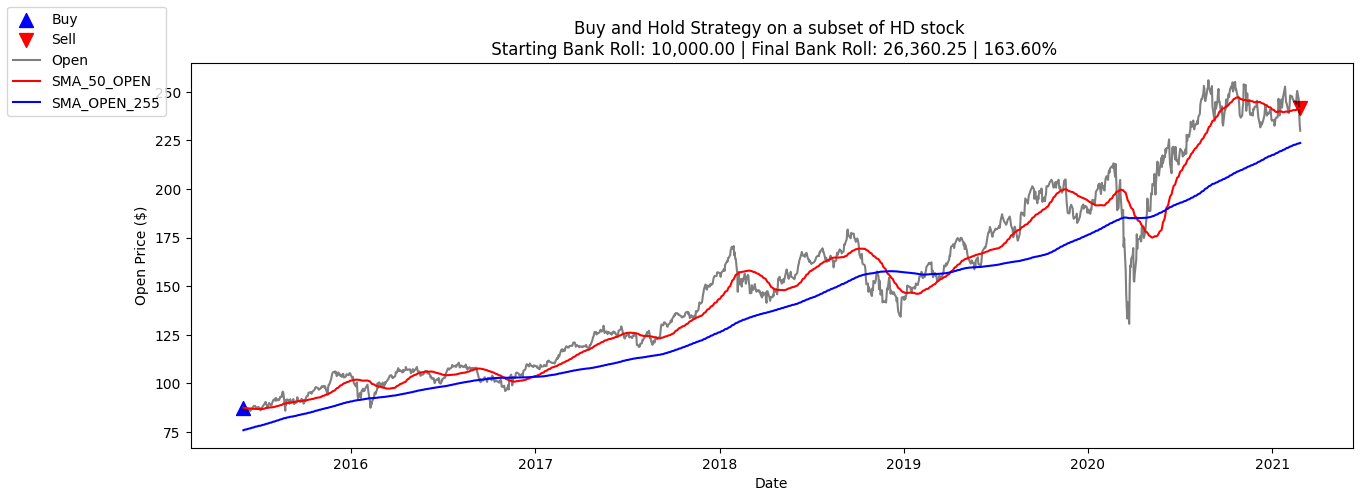

In [293]:
from time import sleep




starting_ammunt = 10_000
inv = Investor("foo", cash=starting_ammunt)

rng = np.random.default_rng()
start = rng.integers(0, len(data.index))
end = rng.integers(start+1, len(data.index))

df = data.iloc[start:end].copy()


fig, ax = plt.subplots()


date = df.index[0]
place_order(inv, "buy",  date, price=df.loc[date]["Open"][stock], shares= (inv.cash // df.loc[date]["Open"][stock] - 1))
plot_buy_sell(ax, "buy", date)

date = df.index[-1]
place_order(inv, "sell",  date, price=df.loc[date]["Open"][stock])
plot_buy_sell(ax, "sell", date)

ax.plot(df.index, df["Open"], label="Open", color="black", alpha=0.5)
ax.plot(df.index, df["SMA_OPEN_50"], label="SMA_50_OPEN", color="r")
ax.plot(df.index, df["SMA_OPEN_255"], label="SMA_OPEN_255", color="b")

if inv.position_open:
    print(f"Closing")
    place_order(inv, "sell",  df.index[-1], price=df.loc[df.index[-1]]["Open"][stock])
    plot_buy_sell(ax, "sell", df.index[-1])

ax.set_title(f"Buy and Hold Strategy on a subset of {stock} stock \n Starting Bank Roll: {starting_ammunt:,.2f} | Final Bank Roll: {round(inv.cash,2):,.2f} | {((inv.cash - starting_ammunt) / starting_ammunt) * 100:,.2f}%")
ax.set_xlabel("Date")
ax.set_ylabel("Open Price ($)")

fig.set_size_inches([15,5])
fig.legend(loc="upper left")
fig.show()
    


In [294]:
# TODO turn percent change into anualized return. 
# TODO implement run_sma_sim and run_buy_hold_sim
# TODO Run statsitical test 
#       - run 100_000 sims for each one on random ticker and random days
#       - Store anualzied return in array for respective strategy
#       - Run test calc p val 



In [295]:
def calc_annualized_return(days: int, total_return: float) -> float:
    if days == 0:
        return 0
    return (1 + total_return) ** (365 / days) - 1


100%|██████████| 1000/1000 [06:00<00:00,  2.77it/s]

Mean: 11.64%
STD: 19.38%


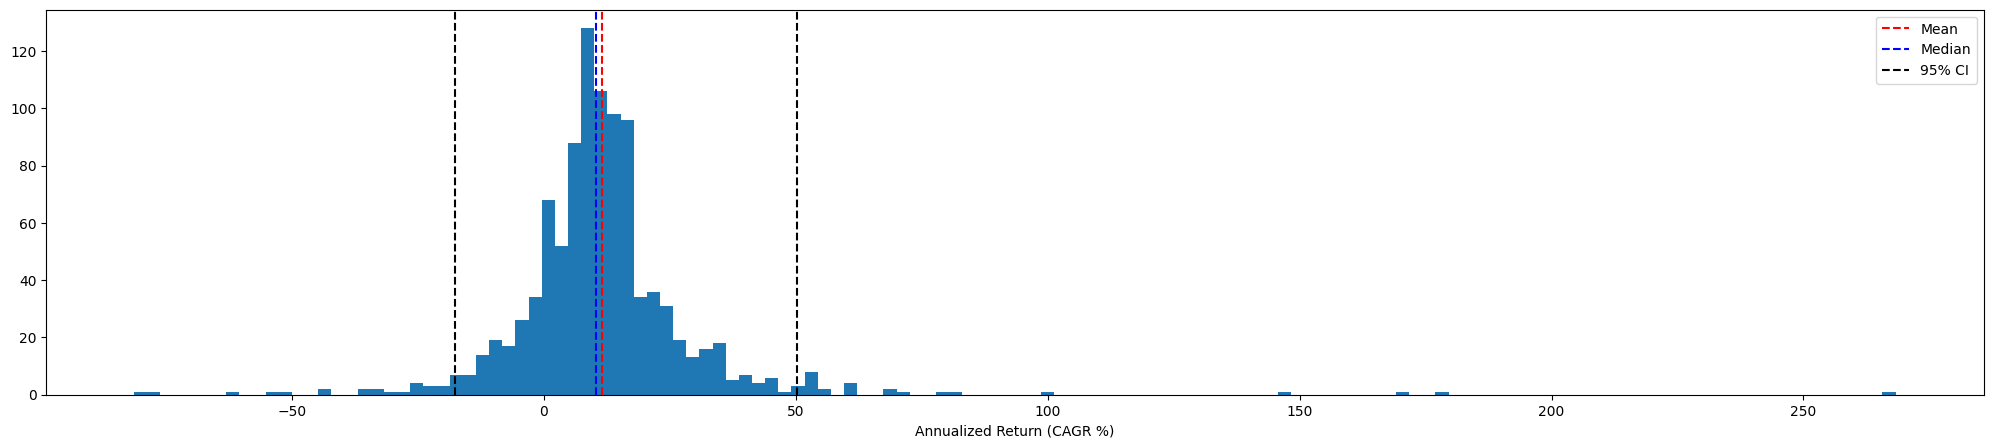

In [296]:
ann_returns = []
EPOCHS = 1000
import time
from tqdm import tqdm


for i in tqdm(range(EPOCHS)):
    starting_ammunt = 10_000
    inv = Investor("SMA", cash=starting_ammunt)


    cooldown_days = 1

    rng = np.random.default_rng()
    start = rng.integers(0, len(data.index))
    end = rng.integers(start+1, len(data.index))

    df = data.iloc[start:end].copy()

    # Spread and sign
    spread = df["SMA_OPEN_50"] - df["SMA_OPEN_255"]
    sign = np.sign(spread)

    # Cross happens when sign changes (ignore zeros by forward filling)
    # Thanks CHAT for this holy 
    sign = sign.replace(0, np.nan).ffill()
    cross = sign.ne(sign.shift(1))  # True on crossover dates
    cross_dates = df.index[cross.fillna(False)]

    last_plotted_date = None

    for date in cross_dates:
        if last_plotted_date is None or (date - last_plotted_date).days >= cooldown_days:
            # Determine direction of cross:
            # if spread goes from negative -> positive => golden cross (buy)
            prev_spread = spread.loc[:date].iloc[-2] if spread.loc[:date].shape[0] >= 2 else -1
            curr_spread = spread.loc[date]

            if prev_spread < 0 and curr_spread > 0:
                if  place_order(inv, "buy",  date, price=df.loc[date]["Open"][stock], shares= (inv.cash // df.loc[date]["Open"][stock] - 1)):
                    plot_buy_sell(ax, "buy", date)
                    last_plotted_date = date

            elif prev_spread > 0 and curr_spread < 0:
                if place_order(inv, "sell",  date, price=df.loc[date]["Open"][stock]):
                    plot_buy_sell(ax, "sell", date)
                    last_plotted_date = date

    if inv.position_open:
        place_order(inv, "sell",  df.index[-1], price=df.loc[df.index[-1]]["Open"][stock])
        plot_buy_sell(ax, "sell", df.index[-1])


    total_return = (inv.cash - starting_ammunt) / starting_ammunt

    days = (df.index[-1] - df.index[0]).days  
    annualized_return = calc_annualized_return(days, total_return)

    ann_returns.append(annualized_return)

fig, ax = plt.subplots()

SMA_ann_returns_pct = np.array(ann_returns) * 100

ax.hist(SMA_ann_returns_pct, bins="auto")
ax.axvline(np.mean(SMA_ann_returns_pct), color="r", linestyle="--", label="Mean")
ax.axvline(np.median(SMA_ann_returns_pct), color="blue", linestyle="--", label="Median")
ax.axvline(np.percentile(SMA_ann_returns_pct, 2.5), color="black", linestyle="--", label="95% CI")
ax.axvline(np.percentile(SMA_ann_returns_pct, 97.5), color="black", linestyle="--")

ax.set_xlabel("Annualized Return (CAGR %)")
ax.legend()

fig.set_size_inches([25,5])

print(f"Mean: {np.mean(SMA_ann_returns_pct):.2f}%")
print(f"STD: {np.std(SMA_ann_returns_pct):.2f}%")


100%|██████████| 1000/1000 [00:00<00:00, 1080.93it/s]


Mean: 18.97%
STD: 28.54%


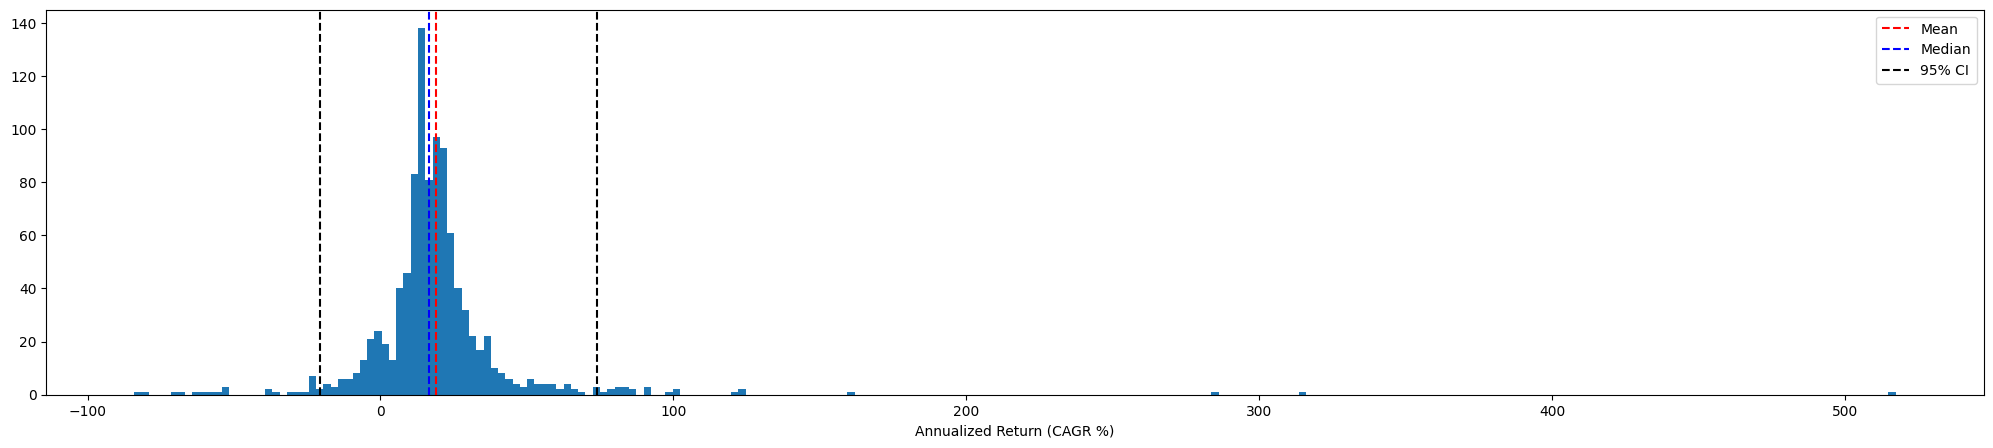

In [297]:
ann_returns = []
import time
from tqdm import tqdm

fig, ax = plt.subplots()

for i in tqdm(range(EPOCHS)):
    starting_ammunt = 10_000
    inv = Investor("Buy and Hold", cash=starting_ammunt)

    rng = np.random.default_rng()
    start = rng.integers(0, len(data.index))
    end = rng.integers(start+1, len(data.index))

    df = data.iloc[start:end].copy()
    
    date = df.index[0]
    place_order(inv, "buy",  date, price=df.loc[date]["Open"][stock], shares= (inv.cash // df.loc[date]["Open"][stock] - 1))

    date = df.index[-1]
    place_order(inv, "sell",  date, price=df.loc[date]["Open"][stock])



    if inv.position_open:
        print(f"Closing")
        place_order(inv, "sell",  df.index[-1], price=df.loc[df.index[-1]]["Open"][stock])


    total_return = (inv.cash - starting_ammunt) / starting_ammunt

    days = (df.index[-1] - df.index[0]).days  
    annualized_return = calc_annualized_return(days, total_return)

    ann_returns.append(annualized_return)


buy_hold_ann_returns_pct = np.array(ann_returns) * 100

ax.hist(buy_hold_ann_returns_pct, bins="auto")
ax.axvline(np.mean(buy_hold_ann_returns_pct), color="r", linestyle="--", label="Mean")
ax.axvline(np.median(buy_hold_ann_returns_pct), color="blue", linestyle="--", label="Median")
ax.axvline(np.percentile(buy_hold_ann_returns_pct, 2.5), color="black", linestyle="--", label="95% CI")
ax.axvline(np.percentile(buy_hold_ann_returns_pct, 97.5), color="black", linestyle="--")

ax.set_xlabel("Annualized Return (CAGR %)")
ax.legend()

fig.set_size_inches([25,5])

print(f"Mean: {np.mean(buy_hold_ann_returns_pct):.2f}%")
print(f"STD: {np.std(buy_hold_ann_returns_pct):.2f}%")


SMA Mean: 11.64% | BH Mean:  18.97%
SMA STD:  19.38% | BH STD:   28.54%


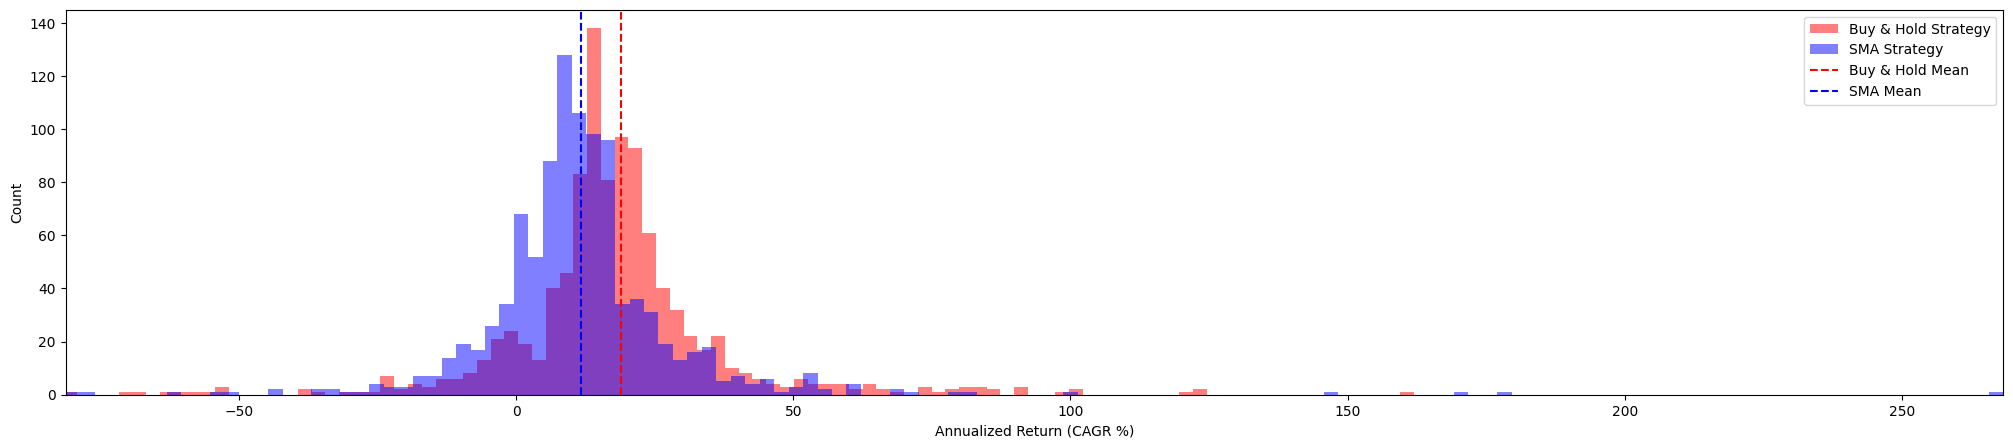

In [317]:
fig, ax = plt.subplots()


ax.hist(
        buy_hold_ann_returns_pct, 
        bins="auto", 
        alpha=0.5, 
        color="red", 
        label="Buy & Hold Strategy"
        )


ax.hist(
        SMA_ann_returns_pct, 
        bins="auto", 
        color="blue", 
        alpha=0.5, 
        label="SMA Strategy"
        )


ax.axvline(np.mean(buy_hold_ann_returns_pct), color="red", linestyle="--", label="Buy & Hold Mean")
ax.axvline(np.mean(SMA_ann_returns_pct), color="blue", linestyle="--", label="SMA Mean")

ax.set_xlabel("Annualized Return (CAGR %)")
ax.set_ylabel("Count")
ax.legend()
fig.set_size_inches([25, 5])

xmin = min(SMA_ann_returns_pct.min(), SMA_ann_returns_pct.min())
xmax = max(SMA_ann_returns_pct.max(), SMA_ann_returns_pct.max())
ax.set_xlim(xmin, xmax)


print(f"SMA Mean: {np.mean(SMA_ann_returns_pct):.2f}% | BH Mean:  {np.mean(buy_hold_ann_returns_pct):.2f}%")
print(f"SMA STD:  {np.std(SMA_ann_returns_pct):.2f}% | BH STD:   {np.std(buy_hold_ann_returns_pct):.2f}%")


In [ ]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(
    SMA_ann_returns_pct,
    buy_hold_ann_returns_pct,
    alternative="greater"
)

print("U statistic:", stat)
print("One-sided p-value (SMA > BH):", p_value)